# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

---

# 1. Загрузка и подготовка данных

### Импортируем необходимые библиотеки

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats as st

### Считываем данные

In [19]:
geo_df_1 = pd.read_csv('/datasets/geo_data_0.csv')
geo_df_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_df_3 = pd.read_csv('/datasets/geo_data_2.csv')

# запишем названия таблиц в отдельную переменную для использования в циклах
regions = [geo_df_1, geo_df_2, geo_df_3]

### Изучаем данные

In [20]:
counter = 1
for region in regions:
    print('-------- Регион {:d} --------'.format(counter))
    print(region.info())
    print(region.head(3))
    print('-----------------')
    print()
    counter +=1

-------- Регион 1 --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
-----------------

-------- Регион 2 --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id         f0        f1        f2    

Имеем 3 три таблицы по **100 000** записей в каждой, пропусков нет.\
Записи в таблицах содержат следующие данные о месторождениях:
- **id** - уникальный идентификатор месторождения
- **f0, f1, f2** - характеристики месторождения
- **product** - объем запасов в месторождении

#### Проверим на наличие дублирующихся значений

In [21]:
for region in regions:
    print(region.duplicated().sum())

0
0
0


#### Подробнее взглянем на то, как признаки распределены, и взаимосвязаны ли они между собой, и если да, то как.

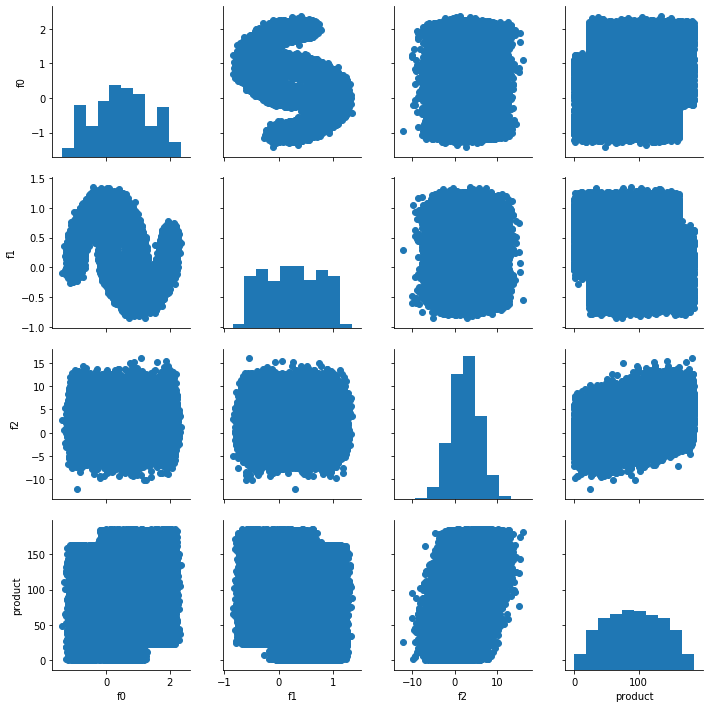

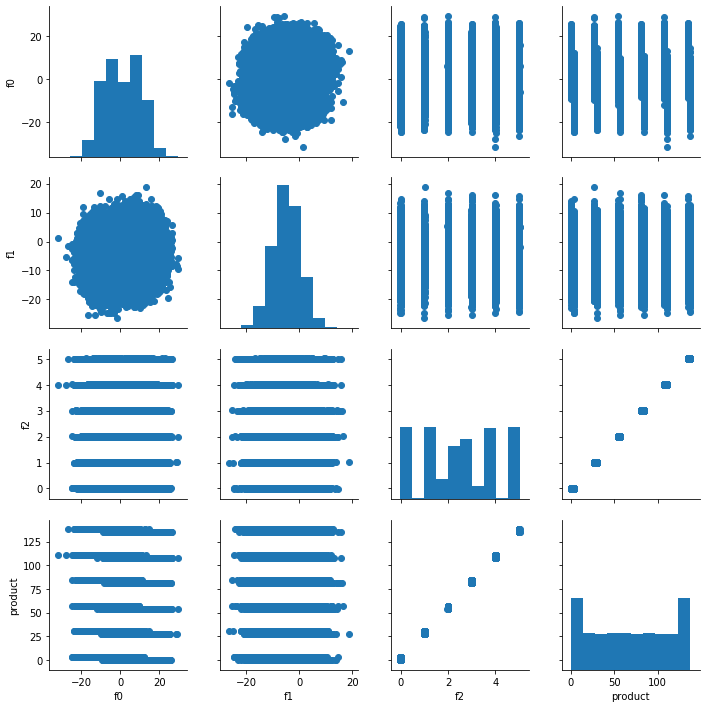

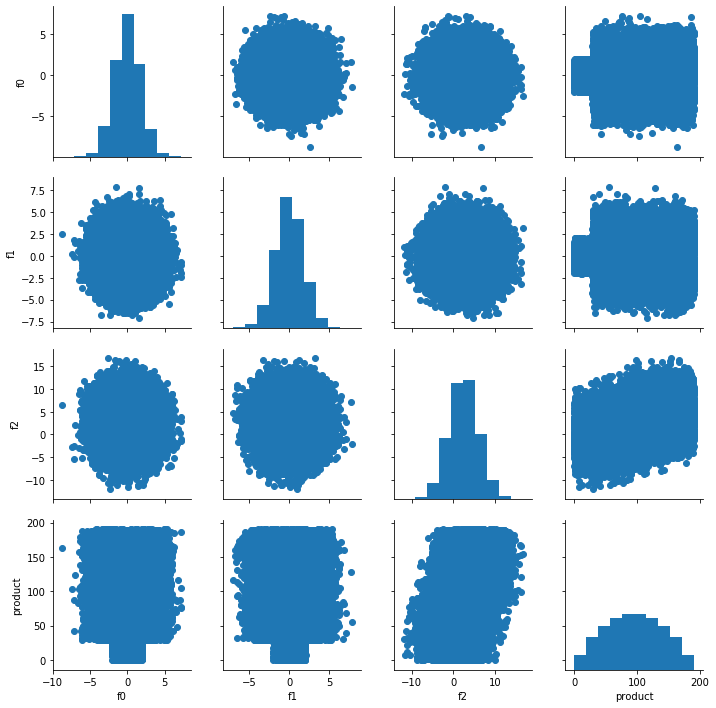

In [22]:
for region in regions:
    g = sns.PairGrid(region)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    print()

По графикам видно, что распределение и взаимосвязь параметров в регионах сильно отличается, крайне неестесственно выглядит второй регион.

**Теперь взглянем на корреляцию параметров:**

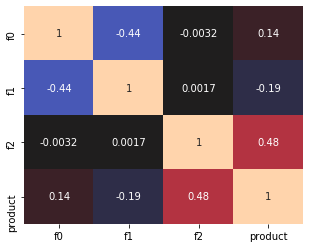

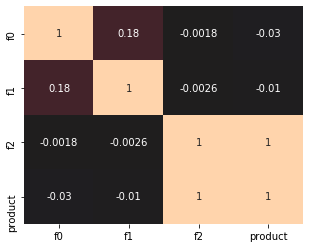

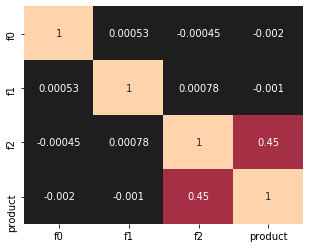

In [23]:
for region in regions:
    plt.figure(figsize=(5,4))
    sns.heatmap(region.corr(), annot=True, cbar=False, center=0)
    print()

(Графики обрезаны сверху и снизу из-за ошибки в текущей версии библиотеки **matplotlib**)

Получаем довольно необычные результаты:
- В **первом** и **третьем** регионах:
    - практически нет корреляции между признаками **f0** **f1** и **объемом** запасов
    - есть обратная корреляция между признаками **f0** и **f1**
    - присутствует средняя корреляция между признаком **f2** и **объемом** запасов
- Во **втором** регионе:
    - нет корреляции между признаком **f0** и **объемом** запасов
    - небольшая корреляция между признаком **f1** и **объемом** запасов
    - прямая корреляция между признаком **f2** и **объемом**

### Задача
Необходимо построить модель, которая предскажет средний объем запасов в месторождениях каждого региона, и на основе этих предсказаний выбрать оптимальный регион для разработки месторождений.

Перед обучением удалим столбец **id**, поскольку он не содержит необходимых для обучения модели данных.

In [24]:
for i in range(3):
    regions[i] = regions[i].drop(['id'], axis=1)

---

# 2. Обучение и проверка модели

По условию задачи необходимо использовать **линейную регрессию**, т.к. другие модели недостаточно предсказуемы.

Поскольку данные в каждом регионе отличаются, целесообразно обучать модель отдельно для каждого региона.\
Создадим функцию **lin_model_train_predict()**, которая:
- **Принимает на вход:** датасет и целевой признак
- Разделяет данные на обучающую и валидационную выборки
- Обучает модель
- Делает предсказания на валидационной выборке
- Выводит средний запас сырья и RMSE модели на валидационной выборке
- **Возвращает:** обученную модель и предсказания

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def lin_model_train_predict(df, target):
    features = df.drop([target], axis=1)
    target = df[target]
    
    train_features, valid_features, train_target, valid_target = train_test_split(
        features, target, test_size=0.25, random_state=42)
    
    # нормируем, поскольку признаки распределены не одинаково
    model = LinearRegression(normalize=True).fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    mse = mean_squared_error(predictions, valid_target)
    print('Средний запас сырья: {:.2f} ||| RMSE:{:.2f}'.format(predictions.mean(), mse**0.5))
    
    return pd.Series(predictions)

Применим функцию для каждого региона, пока не записывая предсказания:

In [26]:
all_predictions = []
count = 1
for region in regions:
    print('----- Регион {:d} -----'.format(count))
    count += 1
    all_predictions.append(lin_model_train_predict(region, 'product'))

----- Регион 1 -----
Средний запас сырья: 92.40 ||| RMSE:37.76
----- Регион 2 -----
Средний запас сырья: 68.71 ||| RMSE:0.89
----- Регион 3 -----
Средний запас сырья: 94.77 ||| RMSE:40.15


Для **первого** и **третьего** регионов предсказания вполне адекватны, более того, как средний объем запасов, так и погрешность предсказаний в этих регионах очень близки.\
На их фоне выделяется **второй** регион. Там **RMSE меньше единицы**, хотя для других регионов этот показатель доходит до **40**.\
Вероятно, такие точные предсказания вызваны прямой корреляцией признака **f2** и запасов во втором регионе.

В остальном же, можем переходить к следующему шагу - расчету прибыли и рисков

---

# 3. Расчёт прибыли и рисков 

Сперва оценим, какое количество месторождений позволяет разработать бюджет:

In [27]:
BUDGET = 10 * 10**9
COST_PER_WELL = 50 * 10**6

WELL_NUMBER = BUDGET / COST_PER_WELL
WELL_NUMBER

200.0

И необходимый для получения прибыли средний объем сырья, исходя из того, что каждая скважина должна себя окупить:

In [28]:
PRICE_PER_THOUSAND_BARRELS = 4500 * 10**3
MINIMAL_MEAN_PRODUCT = COST_PER_WELL / PRICE_PER_THOUSAND_BARRELS
MINIMAL_MEAN_PRODUCT

11.11111111111111

Выходит, для получения прибыли достаточно всего **11 тысяч** баррелей запасов.\
Это в разы меньше ожидаемого среднего количества запасов, предсказанных для каждого региона в прошлом пункте.

### Функция расчета прибыли

Запишем функцию **get_profit()**, которая:
- Принимает на вход предсказания модели для региона
- Из набора предсказаний выбирает 500 случайных значений (такое число точек исследуют при разведке региона)
- Из этих 500 значений выделяет 200 наибольших (столько точек бюджет позволяет освоить)
- Возвращает суммарную стоимость запасов в предсказанных точках

Эта функция в дальнейшем понадобится при использовании техники **bootstrap**.

In [29]:
state = np.random.RandomState(42)
def get_profit(prediction):
    well_500 = prediction.sample(n=500, random_state=state)
    well_200 = well_500.sort_values().head(200)
    return well_200.sum()*PRICE_PER_THOUSAND_BARRELS - BUDGET

Теперь найдем распределение прибыли для регионов, применив процедуру *Bootstrap*.\
Для этого достаточно вызвать функцию **get_profit() 1000** раз для каждого из трех регионов.

In [30]:
all_profit = []

for i in range(3):
    region_profit = []
    for k in range(1000):
        region_profit.append(get_profit(all_predictions[i]))
        
    all_profit.append(pd.Series(region_profit))    

### Общее распределение прибыли по регионам: 

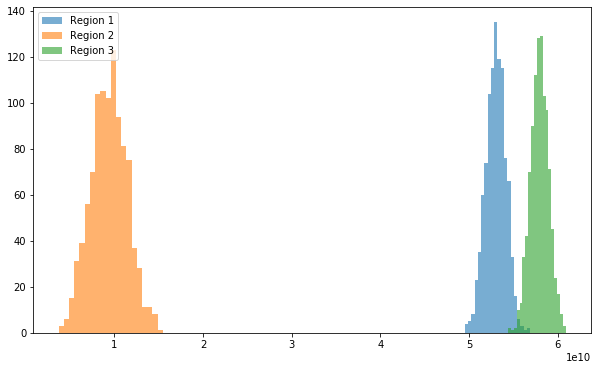

In [31]:
count = 0
region_names = ['Region 1', 'Region 2', 'Region 3']
plt.figure(figsize=(10,6))
for region in region_names:
    plt.hist(all_profit[count], alpha=0.6, bins=20, label=region)
    count+=1
    
plt.legend(loc='upper left')
plt.show()

### По регионам: распределение прибыли, среднее, 95% доверительный интервал и риск убытков

-------------------------------- Region 1 --------------------------------
Распределение прибыли


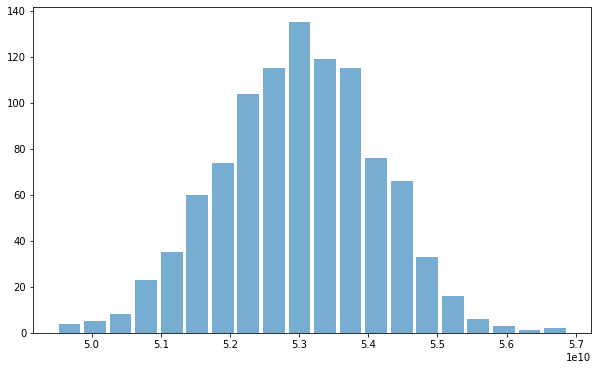

Среднее значение: 52.989 млрд
95% Доверительный интервал: 50.738 млрд - 55.105 млрд
Риск убытков: 0.00%

-------------------------------- Region 2 --------------------------------
Распределение прибыли


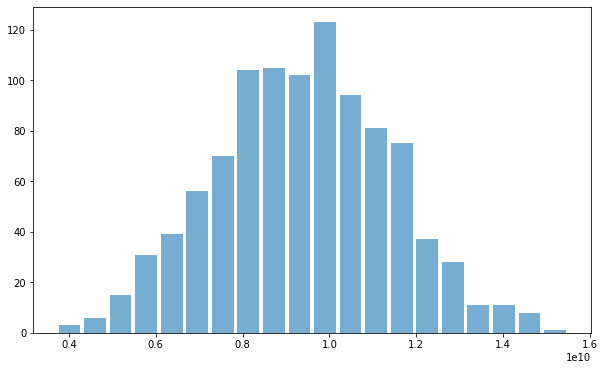

Среднее значение: 9.389 млрд
95% Доверительный интервал: 5.528 млрд - 13.384 млрд
Риск убытков: 0.00%

-------------------------------- Region 3 --------------------------------
Распределение прибыли


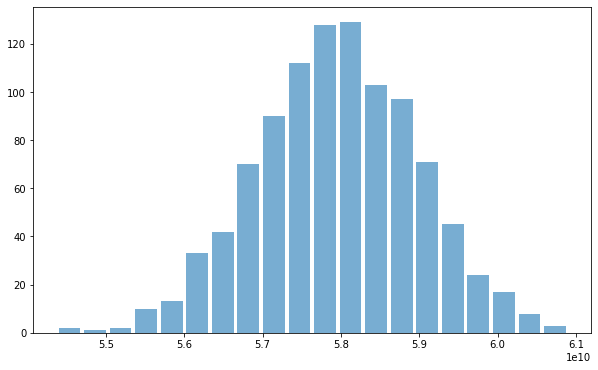

Среднее значение: 57.945 млрд
95% Доверительный интервал: 55.969 млрд - 59.950 млрд
Риск убытков: 0.00%



In [32]:

count = 0
region_names = ['Region 1', 'Region 2', 'Region 3']

for region in region_names:
    print('--------------------------------', region, '--------------------------------')
    
    print('Распределение прибыли')
    plt.figure(figsize=(10,6))
    plt.hist(all_profit[count], alpha=0.6, bins=20, rwidth=0.85)
    plt.show()
    
    print('Среднее значение: {:.3f} млрд'.format(all_profit[count].mean() / 10**9))
    
    # confidence interval borders
    lower = all_profit[count].quantile(0.025)
    upper = all_profit[count].quantile(0.975)
    print('95% Доверительный интервал: {:.3f} млрд - {:.3f} млрд'.format(lower/10**9, upper/10**9))
    
    # chance of getting profit below budget
    print('Риск убытков: {:.2f}%'.format(st.percentileofscore(all_profit[count], 0)))
    print()
    
    count+=1

Выходит, **каждый регион** является **безубыточным**, т.к. **риски равны нулю**.
При этом самым выгодным оказался **третий** регион со значением средней прибыли **58 млрд**.\
Вторым по прибыли идёт **первый** регион, в котором средняя ожидаемая прибыль равна **53 млрд**.\
Наименее перспективным (но тем не менее прибыльным) является **второй** регион. Для него средняя прибыль равна **9 млрд**.

---

# Вывод

Несмотря на то, что при разработках месторождений каждого из регионов, **риск понести убытки равен нулю**, наиболее перспективным для разработки является **третий регион**, т.к. он обладает **наибольшим** среди всех регионов средним значением прибыли в **58 млрд**.

**Наиудший регион** для разработки - **второй**. Предполагаемая средняя прибыль в этом регионе равна **9 млрд**.

---

## Для разработки рекомендуется 3 Регион.